<a href="https://colab.research.google.com/github/savitskaya-om/python/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22SyntheticRubber_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/da-python/python-for-data-analytics/blob/main/Lesson3/hometask/SyntheticRubber.ipynb)

In [2]:
##### При работе в Colab
!pip install yfinance
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 6.4 MB 18.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from bs4 import BeautifulSoup
import os

In [ ]:
# Для работы с API может потребоваться обходное решение для работы с SSL сертификатом
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании.
* Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании.
* Ваши клиенты предпочитают формульный подход к ценообразованию и вам нужно предложить клиентам формулу цены на синтетический каучук, который может быть альтернативой натуральному каучуку с грейдом SMR 20.
* В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


In [4]:
# Из данных есть:
# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии)
# location - локация клиента
# volumes - закупаемые объемы
# comment - предпочитаемая формула расчета цены - скользящая средняя или среднее значение за месяц

customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },

    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


In [5]:
# Котировки натурального каучука доступны на сайте,  https://www.lgm.gov.my
# также у них есть API, пример запроса ниже
#
year = '2022'
month = '05'
url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
res = requests.get(url)
rj = res.json()
df = pd.json_normalize(rj)
df.head()

,date,grade,masa,rm,us,tone
0,2022-05-31,SMR CV,Noon,1157.50,269.20,Slightly steadier
1,2022-05-31,SMR L,Noon,1147.50,266.90,Slightly steadier
2,2022-05-31,SMR 5,Noon,740.00,172.10,Slightly steadier
3,2022-05-31,SMR GP,Noon,737.00,171.40,Slightly steadier
4,2022-05-31,SMR 10,Noon,730.00,169.80,Slightly steadier


In [ ]:
SMR20 = df[df.grade =="SMR 20"][["date","us"]] #price in USD

In [6]:
df = pd.DataFrame()
for y in range(2020, 2022):
  for i in range(1,13):
    url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={i}&year={y}"
    res = requests.get(url)
    rj = res.json()
    df = pd.concat([df, pd.json_normalize(rj)]) 
df.head()

,date,grade,masa,rm,us,tone
0,2020-01-31,SMR CV,Noon,767.50,190.70,Quiet
1,2020-01-31,SMR L,Noon,757.50,188.20,Quiet
2,2020-01-31,SMR 5,Noon,562.50,139.75,Quiet
3,2020-01-31,SMR GP,Noon,559.50,139.00,Quiet
4,2020-01-31,SMR 10,Noon,552.50,137.25,Quiet


In [48]:
SMR20 = df[df.grade =="SMR 20"][["date","us"]] #price in US cents
SMR20['date'] = pd.to_datetime(SMR20['date'], format=('%Y-%m-%d'))
SMR20['date'] = SMR20['date'].dt.date 
SMR20 ["us"] = SMR20["us"]/100
SMR20.head()

AttributeError: ignored

In [8]:
SMR20["us"] = SMR20["us"].astype("float")
SMR20['date'] = pd.to_datetime(SMR20['date'])
SMR20_m = SMR20.set_index("date").resample("M").mean()
SMR20_m

,us
date,
2020-01-31,146.960000
2020-02-29,134.165000
2020-03-31,122.436364
2020-04-30,110.319048
2020-05-31,110.046875
2020-06-30,115.102381
2020-07-31,118.638636
2020-08-31,130.752632
2020-09-30,136.850000


In [9]:
df = yf.download('EURUSD=X')
df = df.Close.copy()
df = df.resample('M').mean()
df = pd.DataFrame(df)
df_rates = df.loc['2020-01-01':'2021-12-31'].copy()
df_rates.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2020-01-31,1.111180
2020-02-29,1.091091
2020-03-31,1.107309
2020-04-30,1.087575
2020-05-31,1.089994


In [10]:
SMR20_m = SMR20_m.join(df_rates)
SMR20_m = SMR20_m.rename(columns = {"us":"SMR20", "Close":"EURUSD"})
SMR20_m.head()

,SMR20,EURUSD
date,,
2020-01-31,146.960000,1.111180
2020-02-29,134.165000,1.091091
2020-03-31,122.436364,1.107309
2020-04-30,110.319048,1.087575
2020-05-31,110.046875,1.089994


In [11]:
main_df = SMR20_m.copy()
main_df["PRICE_EUR"] =  main_df.SMR20 *(1/main_df.EURUSD) + 400
main_df["PRICE_USD"] = main_df.SMR20  + 400 * main_df.EURUSD
main_df['PRICE_EUR_EU'] = main_df['PRICE_EUR'] + EU_LOGISTIC_COST_EUR
main_df['PRICE_USD_CN'] = main_df['PRICE_USD'] + CN_LOGISTIC_COST_USD
main_df['PRICE_EUR_EU_MA'] = main_df.PRICE_EUR_EU.rolling(window=3).mean()
main_df.head()

,SMR20,EURUSD,PRICE_EUR,PRICE_USD,PRICE_EUR_EU,PRICE_USD_CN,PRICE_EUR_EU_MA
date,,,,,,,
2020-01-31,146.960000,1.111180,532.255767,591.432110,562.255767,721.432110,NaN
2020-02-29,134.165000,1.091091,522.964116,570.601269,552.964116,700.601269,NaN
2020-03-31,122.436364,1.107309,510.571128,565.359812,540.571128,695.359812,551.930337
2020-04-30,110.319048,1.087575,501.435806,545.349051,531.435806,675.349051,541.657017
2020-05-31,110.046875,1.089994,500.961004,546.044420,530.961004,676.044420,534.322646


In [12]:
discounts = {100: 0.01, 300: 0.05, 301: 0.1}

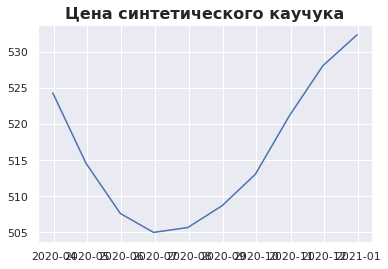

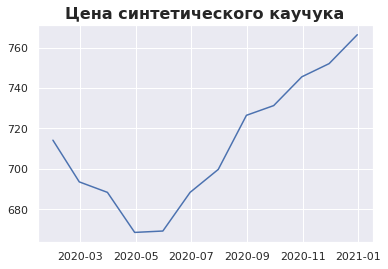

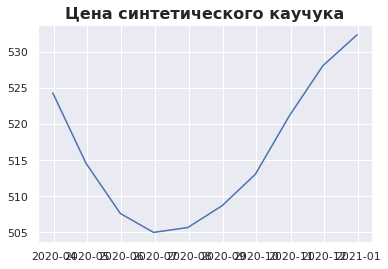

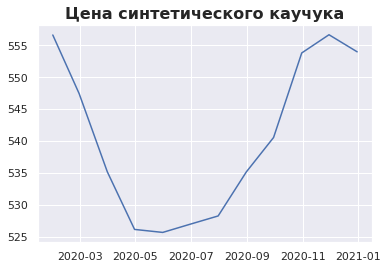

In [16]:
with pd.ExcelWriter('price_proposals.xlsx', engine = 'xlsxwriter') as writer:
    for client, v in customers.items():

        disc = 0.0
        if v.get('location') == "EU":
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            if v.get('comment') == 'monthly':
                client_price = main_df['PRICE_EUR_EU'] * (1-disc)
            elif v.get('comment') == 'moving_average':
                client_price = main_df['PRICE_EUR_EU_MA'] * (1-disc)

        elif v.get('location') == 'CN':
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            client_price = main_df['PRICE_USD_CN'] * (1-disc)

        # print(client, v, disc)
        client_price.to_excel(writer, sheet_name=client)
        # Добавляем график с ценой
        plot_path = f'{client}_SR.png'
        plt.title('Цена синтетического каучука', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        # worksheet = writer.sheets[client]
        # worksheet.insert_image('C2',plot_path)

    for k,v in customers.items():
        worksheet = writer.sheets[k]
        worksheet.insert_image('C2',f"{k}_SR.png")

for k,v in customers.items():
    if os.path.exists(f"{k}_SR.png"):
        os.remove(f"{k}_SR.png")

In [17]:
# Создаем директорию для ценовых предложений клиентам
price_proposals_path = 'client_SR_price_proposals'
if not os.path.exists(price_proposals_path):
    os.mkdir(price_proposals_path)

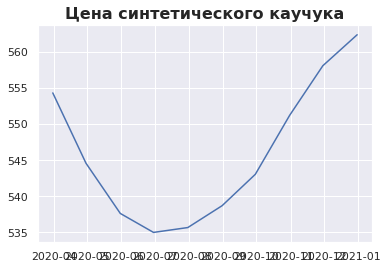

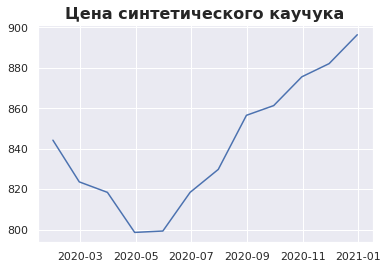

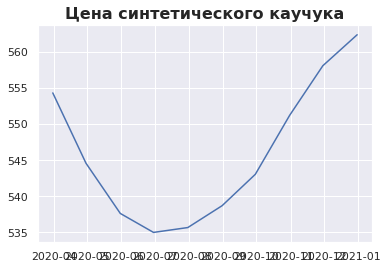

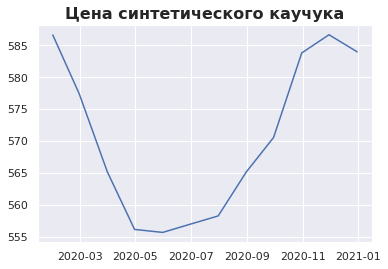

In [19]:
# Создаем отдельный файл для каждого из клиентов
for client, v in customers.items():
    client_proposal_file_path = os.path.join(price_proposals_path, f'{client}_SR_price_proposal.xlsx')
    location = v.get('location')
    disc = 0.0
    if v.get('location') == "EU":
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        if v.get('comment') == 'monthly':
            client_price = main_df['PRICE_EUR_EU'] * (1-disc) + EU_LOGISTIC_COST_EUR
        elif v.get('comment') == 'moving_average':
            client_price = main_df['PRICE_EUR_EU_MA'] * (1-disc) + EU_LOGISTIC_COST_EUR

    elif v.get('location') == 'CN':
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        client_price = main_df['PRICE_USD_CN'] * (1-disc) + CN_LOGISTIC_COST_USD
    with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
        client_price.to_excel(writer, sheet_name='price_proposal')
        # Добавляем график с ценой
        plot_path = f'{client}_SR.png'
        plt.title('Цена синтетического каучука', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        worksheet = writer.sheets['price_proposal']
        worksheet.insert_image('C2',plot_path)

for k,v in customers.items():
    if os.path.exists(f"{k}_SR.png"):
        os.remove(f"{k}_SR.png")

### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента…

### В результате должно быть 3 файла:
1. Ноутбук с расчетами и графиками.
2. Скрипт, который делает расчет цены для каждого клиента в одном файле
2. Скрипт, который делает расчет цены для каждого клиента в отельном файле

# Задание 2. Продолжение

Клиенты согласились на ваше предложение. 
Вам нужно сделать написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

В результате должно быть 3 файла
1. Ноутбук с расчетами и графиками (чтобы данные подтягивались туда)
2. Скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

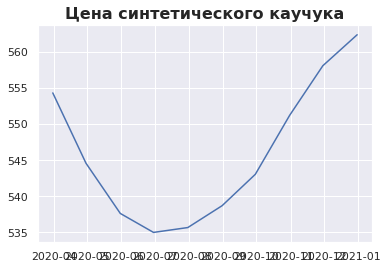

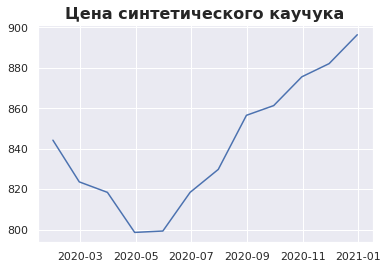

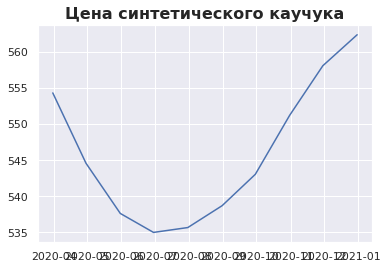

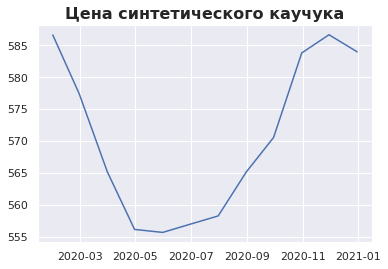

In [20]:
#  # Создаем отдельный файл для каждого из клиентов
for client, v in customers.items():
    client_proposal_file_path = os.path.join(price_proposals_path, f'{client}_SR_price_proposal.xlsx')
    location = v.get('location')
    disc = 0.0
    if v.get('location') == "EU":
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        if v.get('comment') == 'monthly':
            client_price = main_df['PRICE_EUR_EU'] * (1-disc) + EU_LOGISTIC_COST_EUR
        elif v.get('comment') == 'moving_average':
            client_price = main_df['PRICE_EUR_EU_MA'] * (1-disc) + EU_LOGISTIC_COST_EUR

    elif v.get('location') == 'CN':
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        client_price = main_df['PRICE_USD_CN'] * (1-disc) + CN_LOGISTIC_COST_USD
    with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
        client_price.to_excel(writer, sheet_name='price_proposal')
        # Добавляем график с ценой
        plot_path = f'{client}_SR.png'
        plt.title('Цена синтетического каучука', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        worksheet = writer.sheets['price_proposal']
        worksheet.insert_image('C2',plot_path)

for k,v in customers.items():
    if os.path.exists(f"{k}_SR.png"):
        os.remove(f"{k}_SR.png")

# Задание 3. Back to Russia

К вам пришел новый клиент из России, он готов регулярно закупать синтетический каучук. Клиент готов забирать ВБП с завода самостоятельно.
1. На основе тех данных, которые уже есть предложите цену новому клиенту. 
2. Подготовьте скрипт, который будет использовать курс публикуемый на <a href='http://www.cbr.ru/currency_base/dynamics/'> сайте ЦБ РФ</a> или из любого другого источника.


In [44]:
USDRUB = yf.download('USDRUB=X')
USDRUB = USDRUB.Close.copy()
USDRUB = USDRUB.resample('M').mean()
USDRUB = pd.DataFrame(USDRUB)
USDRUB = USDRUB.loc['2020-01-01':'2021-12-31'].copy()
USDRUB.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2020-01-31,61.828313
2020-02-29,63.991130
2020-03-31,74.244732
2020-04-30,75.222187
2020-05-31,72.904476


In [47]:
main_df = main_df.join(USDRUB)
main_df = main_df_3.rename(columns={"Close":"USDRUB"})
main_df["PRICE_RUB"] = main_df.SMR20*main_df.USDRUB  + 400 * main_df.EURUSD*main_df.USDRUB
main_df['PRICE_RUB_MA'] = main_df.PRICE_RUB.rolling(window=3).mean()
main_df.head()

,SMR20,EURUSD,PRICE_EUR,PRICE_USD,PRICE_EUR_EU,PRICE_USD_CN,PRICE_EUR_EU_MA,USDRUB,PRICE_RUB
date,,,,,,,,,
2020-01-31,146.960000,1.111180,532.255767,591.432110,562.255767,721.432110,NaN,61.828313,36567.249648
2020-02-29,134.165000,1.091091,522.964116,570.601269,552.964116,700.601269,NaN,63.991130,36513.419821
2020-03-31,122.436364,1.107309,510.571128,565.359812,540.571128,695.359812,551.930337,74.244732,41974.987666
2020-04-30,110.319048,1.087575,501.435806,545.349051,531.435806,675.349051,541.657017,75.222187,41022.348102
2020-05-31,110.046875,1.089994,500.961004,546.044420,530.961004,676.044420,534.322646,72.904476,39809.082117


# Задание 4. Check it

* Подумайте, как можно проверить корректность работы алгоритма? 
* Какие возможны ошибки?
* Придумайте тесты для проверки возможных ошибок алгоритма
* Интергрируйте их в свои скрипты в виде исключений


In [ ]:
for i in range(len(main_df)):
  if (main_df.EURUSD[i]>1) & (main_df.PRICE_EUR[i] < main_df.PRICE_USD[i]):
    print("conversion from EUR to USD is ok")
  elif (main_df.EURUSD[i]>1) & (main_df.PRICE_EUR[i] > main_df.PRICE_USD[i]): 
    print("check conversion from EUR to USD, it is not ok!")
  elif main_df.PRICE_RUB[i] < main_df.PRICE_USD[i]:
    print ("conversion from USD to RUB is ok")
  elif  main_df.PRICE_RUB[i] > main_df.PRICE_USD[i]:
    print ("check conversion from USD to RUB, it is not ok!")
  else:
    print("unexpected condition")

# Задание 5. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ, но помните о PEP8

In [ ]:
# import yourpackage

# Задание 6. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

* Создайте отдельный пакет, который можно устанавливать с помощью pip 
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в репозиторий

In [ ]:
# !pip install yourpackage
# import yourpackage